## CNN models to predict protein content in corn from NIR specrum

### John A. Osorio 

In the following project, we use the first model proposed by Zhang et al and the model proposed by Cui to predict protein content in corn using a VIR spectrum. CNN is used in the models. The problem is a basic non-linear regression problem in which the output, protein content is predicted with the value of the spectrum in each of the 700 channels. The rmse and $R^2$ metrics are computed, and the predicted and expected data are compared. Good results are obtained.

To reduce the visual impact of this notebook, the Exploratory Data Analysis has been moved to a separate notebook called FinalProject-DataAnalysis.ipynb

### Load dataset and preprocessing

In [1]:
#libraries
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score, mean_squared_error

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, Dense, Flatten, Dropout, Reshape, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = scipy.io.loadmat("corn.mat")

m5spec = data["m5spec"]["data"][0,0]
mp5spec = data["mp5spec"]["data"][0,0]
mp6spec = data["mp6spec"]["data"][0,0]
spec = np.mean([m5spec, mp5spec, mp6spec], axis=0)
moisture, oil, protein, starch = data["propvals"]["data"][0, 0].T.reshape(4, 80)

We average the three spectrums to reduce the complexity of the problem. 

In [39]:
X_data = spec.astype(np.float32)
y_data = protein.astype(np.float32)

TEST_SIZE = 20/80 #specified in the article
(X_train, X_test, y_train, y_test)=train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)

### Model # 1 from Zhang. 

* 1D Conv with 8 filters, stride of 3 and kernel size of 7. 
* Flatten
* F1, with 16 units
* L2 regularizer with $\beta = 0.001$
* Dropout, with rate 0.2
* Exponential learn rate with decay 0.001
* Batch normalization
* We use a Reshape layer to match the X_data and Conv1D dimensions

Hyperparameters for corn, from Table 1 and filters for CNN layers

In [4]:
KERNEL_SIZE_1 = 7
STRIDE_1 = 3
HIDDEN_NUMBER = 16
BATCH_SIZE = 32
DROPOUT_RATE = 0.2
REG_COEF = 0.001
LEARN_RATE = 0.01
LEARN_RATE_DECAY = 0.001

FILTERS_1 = 8

In [5]:
def get_model_zhang(input_shape):
    REG = regularizers.l2(REG_COEF)
    INIT = tf.keras.initializers.he_normal(seed=42)

    model = Sequential([Reshape((input_shape, 1),input_shape=(input_shape,)), 
                        Conv1D(filters = FILTERS_1, kernel_size = KERNEL_SIZE_1, strides = STRIDE_1, padding='same', kernel_initializer=INIT, kernel_regularizer=REG, activation='relu', input_shape=(input_shape, 1)),
                        Flatten(), 
                        BatchNormalization(),
                        Dropout(DROPOUT_RATE),
                        Dense(HIDDEN_NUMBER, kernel_initializer=INIT, kernel_regularizer=REG, activation = 'relu'),
                        BatchNormalization(),
                        Dropout(DROPOUT_RATE),
                        Dense(1, kernel_initializer=INIT, kernel_regularizer=REG, activation = 'linear')])
    return model

def compile_model_zhang(model):
    lr_schedule = ExponentialDecay(
    initial_learning_rate=LEARN_RATE,
    decay_steps=10000,
    decay_rate=LEARN_RATE_DECAY)
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mse'])

In [6]:
tf.random.set_seed(42)
input_shape = X_train.shape[1]
model = get_model_zhang(input_shape)
model.summary()
compile_model_zhang(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 700, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 234, 8)            64        
_________________________________________________________________
flatten (Flatten)            (None, 1872)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1872)              7488      
_________________________________________________________________
dropout (Dropout)            (None, 1872)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                29968     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                6

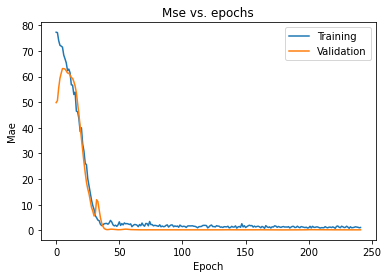

In [7]:
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE, epochs=1500, validation_data=(X_test, y_test), verbose=0, callbacks=[EarlyStopping(monitor='val_loss',patience=50)])
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mse vs. epochs')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

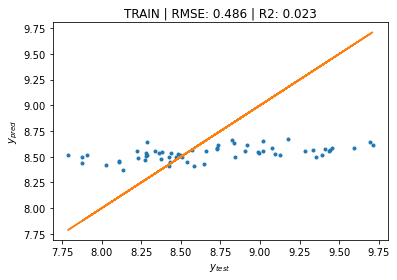

In [8]:
y_pred = model.predict(X_train)
RMSE = np.sqrt(mean_squared_error(y_train,y_pred))

R2 = r2_score(y_train, y_pred)
## Print metrics
plt.plot(y_train, y_pred, '.')
plt.title('TRAIN | RMSE: {:2.3f} | R2: {:2.3f}'.format(RMSE, R2))
plt.xlabel(r"$y_{test}$")
plt.ylabel(r"$y_{pred}$")
plt.plot(y_train, y_train)

plt.show()

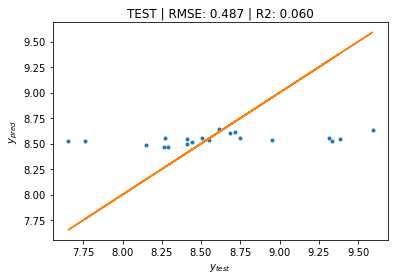

In [9]:
y_pred = model.predict(X_test)
RMSEP = np.sqrt(np.mean((y_test-y_pred)**2))

R2 = r2_score(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
## Print metrics
plt.plot(y_test, y_pred, '.')
plt.title('TEST | RMSE: {:2.3f} | R2: {:2.3f}'.format(RMSE, R2))
plt.xlabel(r"$y$")
plt.ylabel(r"$y_{pred}$")
plt.plot(y_test, y_test)
plt.show()

The data looks horrible! Let's try some scaling.

### Preprocessing 

In [40]:
scaler = StandardScaler().fit(X_train)
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

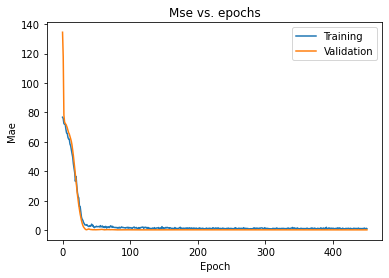

In [41]:
tf.random.set_seed(42)
model = get_model_zhang(input_shape)
compile_model_zhang(model)
history = model.fit(X_train_scal,y_train,batch_size=BATCH_SIZE, epochs=1500, validation_data=(X_test_scal, y_test), verbose=0, callbacks=[EarlyStopping(monitor='val_loss',patience=50)])
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mse vs. epochs')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

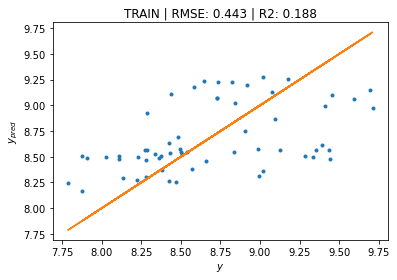

In [45]:
y_pred = model.predict(X_train_scal)
RMSE = np.sqrt(mean_squared_error(y_train,y_pred))

R2 = r2_score(y_train, y_pred)
## Print metrics
plt.plot(y_train, y_pred, '.')
plt.title('TRAIN | RMSE: {:2.3f} | R2: {:2.3f}'.format(RMSE, R2))
plt.xlabel(r"$y$")
plt.ylabel(r"$y_{pred}$")
plt.plot(y_train, y_train)

plt.show()

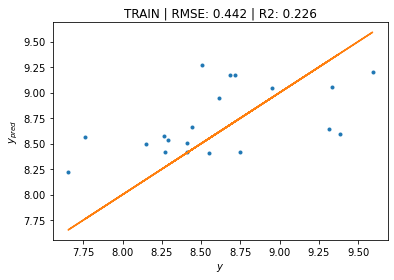

In [44]:
y_pred = model.predict(X_test_scal)
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))

R2 = r2_score(y_test, y_pred)
## Print metrics
plt.plot(y_test, y_pred, '.')
plt.title('TRAIN | RMSE: {:2.3f} | R2: {:2.3f}'.format(RMSE, R2))
plt.xlabel(r"$y$")
plt.ylabel(r"$y_{pred}$")
plt.plot(y_test, y_test)

plt.show()

I had to research hard on this one. The normal scaling doesn't improveme the model cosiderably. However by using the scaling on the rows and then on the columns, we get better results. I found this at https://github.com/dario-passos/DeepLearning_for_VIS-NIR_Spectra

In [46]:
def standardize_row(X_train, X_test):
    scaler = StandardScaler()
    ## rows are scaled individually
    X_train_scaled = scaler.fit_transform(X_train.T)
    X_test_scaled = scaler.fit_transform(X_test.T)
    return [X_train_scaled.T, X_test_scaled.T]

def standardize_column(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return [X_train_scaled, X_test_scaled]

x_train_scaled_col, x_test_scaled_col = standardize_column(X_train, X_test)

## Standardize on rows and columns
x_train_scaled_row, x_test_scaled_row = standardize_row(X_train, X_test)
X_train_scal, X_test_scal = standardize_column(x_train_scaled_row, x_test_scaled_row)

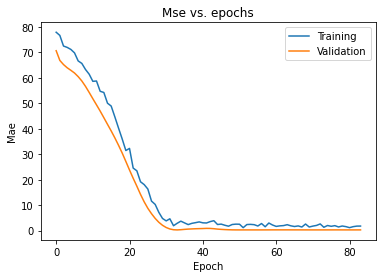

In [47]:
tf.random.set_seed(42)
model = get_model_zhang(input_shape)
compile_model_zhang(model)
history = model.fit(X_train_scal,y_train,batch_size=BATCH_SIZE, epochs=1500, validation_data=(X_test, y_test), verbose=0, callbacks=[EarlyStopping(monitor='val_loss',patience=50)])
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mse vs. epochs')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

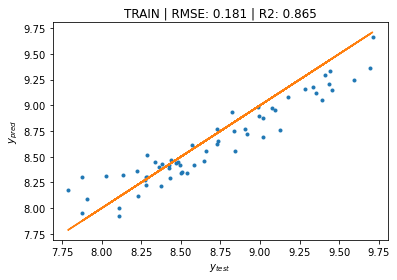

In [12]:
y_pred = model.predict(X_train_scal)
RMSE = np.sqrt(mean_squared_error(y_train,y_pred))

R2 = r2_score(y_train, y_pred)
## Print metrics
plt.plot(y_train, y_pred, '.')
plt.title('TRAIN | RMSE: {:2.3f} | R2: {:2.3f}'.format(RMSE, R2))
plt.xlabel(r"$y_{test}$")
plt.ylabel(r"$y_{pred}$")
plt.plot(y_train, y_train)

plt.show()

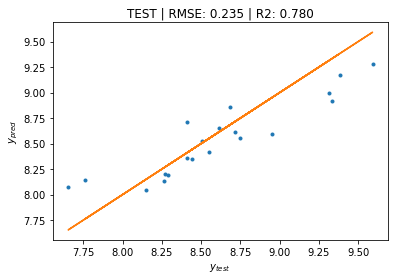

In [13]:
y_pred = model.predict(X_test_scal)
RMSEP = np.sqrt(np.mean((y_test-y_pred)**2))

R2 = r2_score(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
## Print metrics
plt.plot(y_test, y_pred, '.')
plt.title('TEST | RMSE: {:2.3f} | R2: {:2.3f}'.format(RMSE, R2))
plt.xlabel(r"$y_{test}$")
plt.ylabel(r"$y_{pred}$")
plt.plot(y_test, y_test)
plt.show()

It improved, but still not very promising! However, our R2 is better than the one in Zhang!

## Model # 2

* 1D Conv with 1 filter, stride of 1 and kernel size of 5. 
* Flatten
* F1, with 8 units
* F2, with 4 units
* F3, with 2 units
* L2 regularizer with $\beta = 0.001$

These parameters were chosen by trial and error. 

In [32]:
FILTER = 1
KERNEL_SIZE = 5
STRIDE = 1
F1_UNITS = 8
F2_UNITS = 4
F3_UNITS = 2
INIT = tf.keras.initializers.he_normal(seed=42)

## Weights L2 regularization 
REG = tf.keras.regularizers.l2(REG_COEF)

def get_model_cui(input_shape):
    model = Sequential([ Reshape((input_shape, 1),input_shape=(input_shape,)),
                        Conv1D(filters=FILTER,  kernel_size=KERNEL_SIZE, strides= STRIDE, padding='same', kernel_initializer=INIT, kernel_regularizer=REG, activation='relu', input_shape=(input_shape,1)),
                                Flatten(),
                                Dense(F1_UNITS, kernel_initializer=INIT,  kernel_regularizer=REG, activation='relu'),
                                Dense(F2_UNITS, kernel_initializer=INIT, kernel_regularizer=REG, activation='relu'),
                                Dense(F3_UNITS, kernel_initializer=INIT, kernel_regularizer=REG, activation='relu'),
                                Dense(1, kernel_initializer=INIT, kernel_regularizer=REG, activation='linear'),
                              ])
    return model

def compile_model_cui(model):
    model.compile(Adam(learning_rate=LEARN_RATE), loss='mse', metrics=['mse'])  


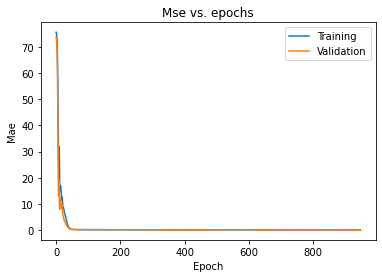

In [33]:
tf.random.set_seed(42)
model = get_model_cui(input_shape)
compile_model_cui(model)
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE, epochs=1500, validation_data=(X_test, y_test), verbose=0, callbacks=[EarlyStopping(monitor='val_loss',patience=50)])
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mse vs. epochs')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

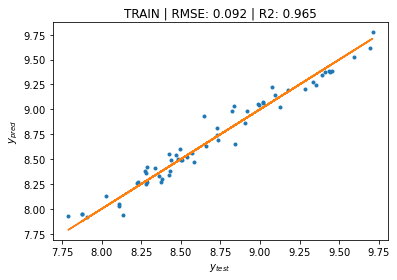

In [34]:
y_pred = model.predict(X_train)
RMSE = np.sqrt(mean_squared_error(y_train,y_pred))

R2 = r2_score(y_train, y_pred)
## Print metrics
plt.plot(y_train, y_pred, '.')
plt.title('TRAIN | RMSE: {:2.3f} | R2: {:2.3f}'.format(RMSE, R2))
plt.xlabel(r"$y_{test}$")
plt.ylabel(r"$y_{pred}$")
plt.plot(y_train, y_train)

plt.show()

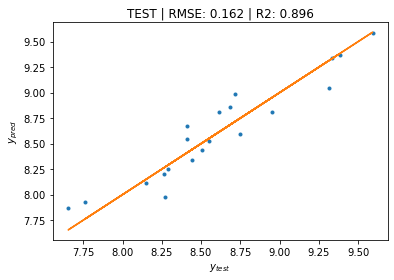

In [35]:
y_pred = model.predict(X_test)
RMSEP = np.sqrt(np.mean((y_test-y_pred)**2))

R2 = r2_score(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
## Print metrics
plt.plot(y_test, y_pred, '.')
plt.title('TEST | RMSE: {:2.3f} | R2: {:2.3f}'.format(RMSE, R2))
plt.xlabel(r"$y_{test}$")
plt.ylabel(r"$y_{pred}$")
plt.plot(y_test, y_test)
plt.show()

Text(0, 0.5, 'protein')

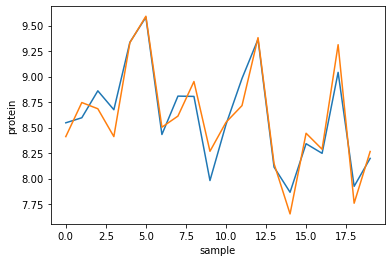

In [36]:
plt.plot(y_pred)
plt.plot(y_test)
plt.xlabel("sample")
plt.ylabel("protein")

It now appears to be adequate!

### Comments 

We validated Zhang's first model and discovered that data scaling was required. The results for R2 were similar, but the model in general does not perform well. Cui's second model, on the other hand, performs well on this dataset. Both model will most likely perform better with a larger dataset.

We did not implement the DeepSpectra due to its complexity, but it would have been interesting to compare the results. 